In [2]:
!pip3 install imblearn
!pip3 install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 3.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 8.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

# 1. READ-IN DATA TO DF

In [4]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [7]:
df["label"].value_counts()

0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: label, dtype: int64

# 2. DELETE 8k RANDOM IMAGES & SHUFFLE

In [8]:
# delte 7802 random images from the category with label 0
df_us = df.drop(df[df["label"] == 0].sample(7702, random_state=1).index)
df_us["label"].value_counts()

0    1100
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: label, dtype: int64

In [9]:
# shuffle the dataframe
df_us = df_us.sample(frac=1, random_state=1).reset_index(drop=True)
df_us.head(5)

,image,label
0,ESP_018720_2655_RED-0035.jpg,2
1,ESP_046991_0950_RED-0024.jpg,7
2,ESP_039350_1915_RED-0186.jpg,1
3,ESP_014156_1865_RED-0023.jpg,3
4,ESP_013049_0950_RED-0088.jpg,7


# 3. READ-IN TO PIXELS

In [10]:
def load_images_labels_from_df(df, folder):
    images = []
    labels = []
    for i in range(len(df)):
        img = cv2.imread(folder+"/"+df.iloc[i][0], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(df.iloc[i][1])
    return np.array(images), np.array(labels)

In [11]:
X, y = load_images_labels_from_df(df_us, "map-proj-v3_2")
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
print(X.shape[0])

[0 1 2 3 4 5 6 7] [1100  794  166  267  250   74  298  164]
3113


# 4. NORMALIZE DATA TO 0-1

In [12]:
X_norm = X / 255.0
print(X_norm.min())
print(X_norm.max())

0.0
1.0


# 5. TRAIN-TEST SPLIT

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2179, 227, 227) (934, 227, 227) (2179,) (934,)


In [35]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train, return_counts=True)[1]/y_train.shape[0])

print(np.unique(y_test, return_counts=True))
print(np.unique(y_test, return_counts=True)[1]/y_test.shape[0])

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([774, 539, 115, 176, 183,  52, 222, 118]))
[0.35520881 0.24736117 0.0527765  0.080771   0.08398348 0.02386416
 0.1018816  0.05415328]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([326, 255,  51,  91,  67,  22,  76,  46]))
[0.3490364  0.27301927 0.05460385 0.09743041 0.07173448 0.0235546
 0.08137045 0.04925054]


In [33]:
max_images = np.unique(y_train, return_counts=True)[1].max()
n_images = np.unique(y_train, return_counts=True)[1]
classes = np.unique(y_train, return_counts=True)[0]
diff = =

for i in classes:
    if n_images[i] < max_images:

    
    print(n_images[i])


774
539
115
176
183
52
222
118


# 6. IMBALANCE HANDLING

# 6.1 ADASYN

In [20]:
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(2179, 227, 227)
(2179, 51529)


In [21]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train)

In [22]:
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
print(X_train_adasyn.shape)
print(unique, counts)
print(unique_a, counts_a)

(6226, 51529)
[0 1 2 3 4 5 6 7] [774 539 115 176 183  52 222 118]
[0 1 2 3 4 5 6 7] [774 824 763 772 789 762 760 782]


In [23]:
# sort the array counts_a
np.sort(counts_a)
np.average(counts_a)

778.25

In [24]:
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227)
y_t_A = y_train_adasyn
print(X_t_A.shape)
print(y_t_A.shape)

(6226, 227, 227)
(6226,)


# 6.2 OVERSAMPLING

# 6. AUGMENTATION
1. Flip H
2. Flip V
3. Zoom
4. Random Brightness Adjustments
5. Rotate 90
6. Rotate 180
7. Rotate 270
8. Contrast adjustment
9. Random Noise


# 7. Apply Own Model
- Hyperparameter Optimization

In [25]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 5, activation="relu", padding="same",
                        input_shape=(227,227, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [26]:
# display the architecture of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 113, 113, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [27]:
# Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_t_A, y_t_A, epochs=10, 
                    validation_split=0.2, batch_size=32)

Epoch 1/10


2023-05-13 14:18:16.209089: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/leonardbrenk/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


156/156 [==============================] - 72s 430ms/step - loss: 1.7699 - accuracy: 0.3203 - val_loss: 2.7848 - val_accuracy: 0.0273
Epoch 2/10
156/156 [==============================] - 65s 416ms/step - loss: 1.3668 - accuracy: 0.5155 - val_loss: 2.2223 - val_accuracy: 0.2825
Epoch 3/10
156/156 [==============================] - 64s 413ms/step - loss: 1.0558 - accuracy: 0.6402 - val_loss: 2.7922 - val_accuracy: 0.0706
Epoch 4/10
156/156 [==============================] - 64s 412ms/step - loss: 0.8370 - accuracy: 0.7135 - val_loss: 2.0525 - val_accuracy: 0.3347
Epoch 5/10
156/156 [==============================] - 64s 411ms/step - loss: 0.5850 - accuracy: 0.8008 - val_loss: 1.8934 - val_accuracy: 0.3628
Epoch 6/10
156/156 [==============================] - 64s 413ms/step - loss: 0.4306 - accuracy: 0.8552 - val_loss: 1.4176 - val_accuracy: 0.4615
Epoch 7/10
156/156 [==============================] - 65s 416ms/step - loss: 0.3234 - accuracy: 0.8882 - val_loss: 1.1045 - val_accuracy: 0.5

30/30 - 4s - loss: 2.0527 - accuracy: 0.6028 - 4s/epoch - 133ms/step
0.602783739566803


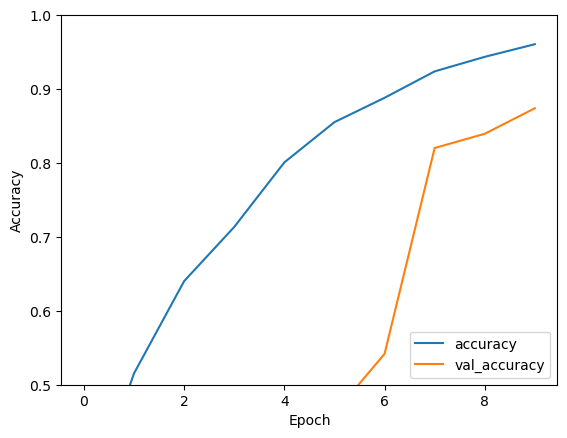

In [29]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right') 

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

In [ ]:
y_pred_prob = model.predict(test_images)
y_pred_class = y_pred_prob.argmax(axis=-1)
print(test_images.shape)
print(y_pred_prob.shape)
print(y_pred_class.shape)

4/4 [==============================] - 14s 3s/step
(100, 227, 227, 3)
(100, 8)
(100,)


In [ ]:
print(y_pred_prob[0])
print(y_pred_class[0])

[9.9999994e-01 2.6889354e-11 8.3544468e-17 4.7753709e-17 5.1388053e-17
 1.1390982e-16 7.6560248e-13 1.3972278e-18]
0


In [ ]:
print(np.unique(test_labels))
print(np.unique(y_pred_class))

[0 1 2 3 4 6 7]
[0]


In [ ]:
#print(class_names)
print(classification_report(y_pred_class, test_labels))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       100
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.75       100
   macro avg       0.14      0.11      0.12       100
weighted avg       1.00      0.75      0.86       100



/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344:

# 8. Apply Pre-trained Model

# ADASYN Experiments

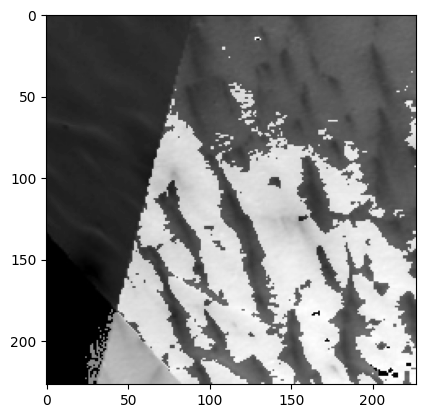

In [ ]:
plt.imshow(X_reshaped_reshaped[65301], cmap="gray")

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

index = np.random.permutation(len(X_reshaped_reshaped))


# function that shows 25 random images from a dataset with their labels
def show_images(X, y, class_names):
    plt.figure(figsize=(10,10))
    counter = 0
    for i in index[:25]:
        plt.subplot(5,5,counter+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[index[i]], cmap=plt.cm.binary)
        plt.xlabel(str(class_names[y[index[i]]])+ " " + str(i))
        counter += 1
    plt.show()

IndexError: index 66387 is out of bounds for axis 0 with size 7783

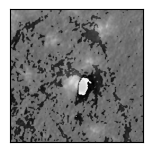

In [ ]:
show_images(X_reshaped_reshaped, y_res, class_names)

In [ ]:
df.iloc[0][0], df.iloc[0][1]

('ESP_013049_0950_RED-0067.jpg', 7)

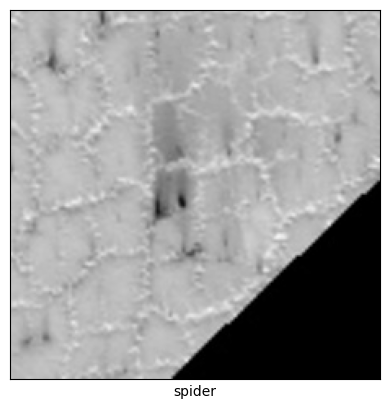

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

plt.imshow(cv2.imread("map-proj-v3_2/" + df.iloc[0][0]))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel(class_names[df.iloc[0][1]])
plt.show()

In [ ]:
def split_train_test(data, folder, test_ratio, number_of_images):
    shuffled_indices = np.random.permutation(len(data)) # indices in shuffled order
    test_set_size = int(len(data) * test_ratio) # size of test set
    
    train = data.iloc[shuffled_indices[:test_set_size]] # first x rows of data (train set)
    test = data.iloc[shuffled_indices[test_set_size:]] # last x rows of data (test set)

    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    for i in range(len(train)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+train.iloc[i][0])
        if img is not None:
            train_images.append(img)
            train_labels.append(train.iloc[i][1])
    for i in range(len(test)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+test.iloc[i][0])
        if img is not None:
            test_images.append(img)
            test_labels.append(test.iloc[i][1])

    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

In [ ]:
train_images, train_labels, test_images, test_labels = split_train_test(df, "map-proj-v3_2/", 0.2, 100)
print("train images:", type(train_images), "\ntest images:", type(test_images), # numpy arrays of images
      "\ntrain labels:", type(train_labels), "\ntest labels:", type(test_labels)) # lists of labels

print(train_labels[:5]) # 5 labels
print(train_images.shape) # 100 images, 256x256, 3 channels

train images: <class 'numpy.ndarray'> 
test images: <class 'numpy.ndarray'> 
train labels: <class 'numpy.ndarray'> 
test labels: <class 'numpy.ndarray'>
[0 4 0 0 0]
(100, 227, 227, 3)


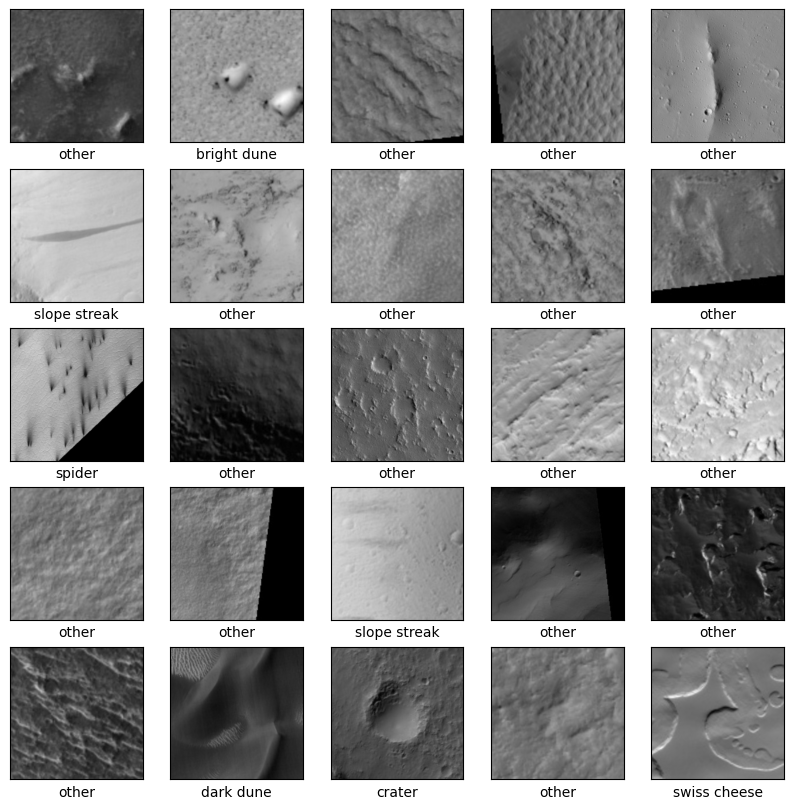

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

model = models.Sequential()

# Convolutional Base
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense Layer ontop
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8), activation='softmax')

# OLD CODE

------------------------------------------------------------------------------------------------

def load_images_from_folder_excel(folder, mapping, number_of_images):
    images = []
    labels = []
    for i in range(len(mapping)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+mapping.iloc[i][0])
        if img is not None:
            images.append(img)
            labels.append(mapping.iloc[i][1])
    return images, labels

train_images, train_labels = load_images_from_folder_excel("map-proj-v3_2", mapping, 100)
print(len(train_images))
print(train_labels[:5])
print(train_images[:5])

In [ ]:
def load_images_labels_from_df_num(df, folder, number_of_images=1000):
    shuffled_indices = np.random.permutation(len(df)) # indices in shuffled order
    
    # get thos values from df that are in the shuffled_indices list
    df = df.iloc[shuffled_indices[:number_of_images]]
    images = []
    labels = []
    for i in range(len(df)):
        img = cv2.imread(folder+"/"+df.iloc[i][0], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(df.iloc[i][1])
    return np.array(images), np.array(labels)

In [ ]:
X, y = load_images_labels_from_df_num(df_us, "map-proj-v3_2")
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([803,  89,  10,  30,  17,   7,  29,  15]))